In [1]:
import tensorflow as tf
tf.test.is_gpu_available()

True

In [2]:
tf.config.experimental.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:DML:0', device_type='DML')]

In [3]:
gpu_config = tf.GPUOptions()
gpu_config

In [6]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:DML:0 -> {"name": "AMD Radeon(TM) Graphics", "vendor_id": 4098, "device_id": 5708, "driver_version": "30.0.13032.0"}



In [7]:
sess.list_devices

<bound method BaseSession.list_devices of <tensorflow.python.client.session.Session object at 0x000001C92E3F9B48>>

In [8]:
gpu_config

# Import all libraries

In [9]:
import random
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import hdbscan
import tensorflow as tf
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer
import scipy.cluster.hierarchy as shc
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)
import tensorflow as tf
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string

nltk.download('punkt')
from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from sklearn.metrics import confusion_matrix,classification_report



C:\Users\Ajay\Anaconda3\envs\python3-directml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ajay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ajay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ajay\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ajay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Import dataset

In [10]:
df=pd.read_csv(r'C:\Users\Ajay\Documents\Code\EXL\Projects\Retail Pharmacy\TextClustering\Data\2021VAERSDATA.csv',encoding='latin1')

C:\Users\Ajay\Anaconda3\envs\python3-directml\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (7,12,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Helper functions

In [11]:
def plot_kmeans(embeddings, k_range):
    '''
    Plot SSE and silhouette score for kmeans clustering for a range of k values
    Arguments:
        embeddings: array, sentence embeddings
        k_range: range, values of k to evaluate for kmeans clustering  
    '''
    sse = []
    silhouette_avg_n_clusters = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=50, n_init=1)
        kmeans.fit(embeddings)
        sse.append(kmeans.inertia_)

        silhouette_avg = silhouette_score(embeddings, kmeans.predict(embeddings))
        silhouette_avg_n_clusters.append(silhouette_avg)


    # plot sse
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].plot(k_range, sse)
    axes[0].set(xlabel = 'k clusters', ylabel = 'SSE', title = 'Elbow plot')
    axes[0].grid()
    
    # plot avg silhouette score
    axes[1].plot(k_range, silhouette_avg_n_clusters)
    axes[1].set(xlabel = 'k clusters', ylabel = 'Silhouette score', title = 'Silhouette score')
    axes[1].grid()

    plt.show()

def search_cluster_size(embeddings, size_range):
    '''
    Scan HDBSCAN min_cluster_size values and return results
    Arguments:
        embeddings: embeddings to use
        size_range: range of min_cluster_size hyperparameter values to scan
    Returns:
        result_df: dataframe of min_cluster_size, total number of clusters,
                   and percent of data labeled as noise
    '''
    
    results = []
    
    for i in size_range:
        min_cluster_size = i
        
        clusters_hdbscan = (hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                           metric='euclidean', 
                                           cluster_selection_method='eom') 
                                           .fit(embeddings))
    
        labels = clusters_hdbscan.labels_
        label_count = len(np.unique(labels))
        
        total_num = len(clusters_hdbscan.labels_)
        cost = (np.count_nonzero(clusters_hdbscan.probabilities_ < 0.05)/total_num) 
                
        results.append([min_cluster_size, label_count, cost])
    
    result_df = pd.DataFrame(results, columns=['min_cluster_size', 
                                               'label_count', 'noise'])
    
    return result_df

def random_search(embeddings, space, num_evals):
    '''
    Random search of HDBSCAN hyperparameter spcae
    Arguments:
        embeddings: embeddings to use
        space: dict, hyperparameter space to search with keys of
               'min_cluster_size' and 'min_samples' and values as ranges
        num_evals: int, number of trials to run
    Returns:
        result_df: dataframe of run_id, min_cluster_size, min_samples, 
                   total number of clusters, and percent of data labeled as noise
    
    '''
    
    results = []
    
    for i in range(num_evals):
        min_cluster_size = random.choice(space['min_cluster_size'])
        min_samples = random.choice(space['min_samples'])
        
        clusters_hdbscan = (hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                           min_samples = min_samples,
                                           metric='euclidean', 
                                           cluster_selection_method='eom') 
                                           .fit(embeddings))
    
        labels = clusters_hdbscan.labels_
        label_count = len(np.unique(labels))
        
        total_num = len(clusters_hdbscan.labels_)
        cost = (np.count_nonzero(clusters_hdbscan.probabilities_ < 0.05)/total_num) 
                
        results.append([i, min_cluster_size, min_samples, label_count, cost])
    
    result_df = pd.DataFrame(results, columns=['run_id', 'min_cluster_size', 'min_samples', 
                                               'label_count', 'cost'])
    
    return result_df.sort_values(by='cost')

# Removing null values and data preprocessing 

In [12]:
df = df[df['SYMPTOM_TEXT'].notna()]

# Data preprocessing for Non - contextual embedding - TF-idf and BOW

In [14]:
# NLP text tokens


def tokenize(text):
    words=word_tokenize(text)
    return words
# removing stopwords
stop=stopwords.words('english')
puncs=list(string.punctuation)
stop=stop+puncs
def remove_stops(words):
    cleaned=[w for w in words if not w.lower() in stop]
    return cleaned
# document parsing
def pos_tg(cleaned):
    pos=np.array(pos_tag(cleaned))
    return pos

def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# lemitizing
lemmatizer=WordNetLemmatizer()

def lemmatize(pos):
    lemmatized=[]
    for w in pos:
        lemmatizedword=lemmatizer.lemmatize(w[0],get_simple_pos(w[1]))
        lemmatized.append(lemmatizedword)
    return lemmatized
def preprocess(text):
    words=tokenize(text)
    cleaned=remove_stops(words)
    pos=pos_tag(cleaned)
    lemmatized=lemmatize(pos)
    preprocessed=" ".join(lemmatized)
#     sno = nltk.stem.SnowballStemmer('english')
    
    return preprocessed

In [15]:
#
# data preprocessing step where some characters which are not required are removed 
# 1. special characters
# 2. digits in this use case
# 3. extra spaces
# 4. some words like block are used in lot of sentences and is surrounded by other characters ..needed to be separated
# 5 words less than  3 and greater than 20 add no meaning to data , so those are also removed
worddic={}
rows=[]
for i in df.index:
    row=df['SYMPTOM_TEXT'][i]
    row=df['SYMPTOM_TEXT'][i].lower()
    
    row=re.sub('[^A-Za-z]+', ' ', row)
    tokens=row.split(" ")
    tokens=[t.lower() for t in tokens if len(t)>=3 and len(t)<20]
    text=" ".join(tokens)

    row=preprocess(text)
    tokens=row.split(" ")
    for j in tokens:
        worddic[j]=worddic.get(j,0)+1
    rows.append(row)
    

# Kmeans with BOW

In [16]:

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(rows)
df_bow_sklearn = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
df_bow_sklearn.head()

C:\Users\Ajay\Anaconda3\envs\python3-directml\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaa,aafter,aaox,aat,ab,aba,aback,abaloparatide,abate,abated,abbott,abbt,abc,abcess,abcs,abd,abdmen,abdomainl,abdomen,abdomid,abdomin,abdominal,abdominla,abdomino,abdominopelvic,abducen,abduct,abduction,abduscens,abg,abgs,abilify,ability,abiraterone,abixaban,abl,ablation,able,abn,abnl,abnominal,abnormal,abnormality,abnormally,abo,abolish,abort,abortion,abot,abotut,abour,abrasion,abreva,abroximately,abrupt,abruption,abruptly,abs,abscess,abscessus,abscsses,absence,absent,absolute,absolutely,absolve,absorb,abstain,abstract,abt,abulated,abundance,abuse,abut,abv,abx,ac,acacia,acalculous,acarbose,acausal,acc,accelerate,accelerated,accelerator,accept,acceptable,acceptance,accepted,accepts,access,accessory,accident,accidental,accidentally,accidently,accomandate,accomapanied,accompanied,accompany,accomplish,accord,accordance,accordingly,account,accoured,accredo,accreta,accross,accrual,accrue,accu,accucheck,accuchecks,accumulate,accumulation,accuracy,accurate,accurately,accuretic,accustom,accutane,accute,acdf,ace,acebutolol,acellular,acet,acetadote,acetam,acetamenophen,acetamide,acetaminohen,acetaminophen,acetate,acetazolamide,acetic,acetiminophen,acetminophen,acetomenphin,acetominophen,acetonide,acetyl,acetylcarnitine,acetylcholine,acetylcysteine,acetylsalicyclic,acetylsalicylic,acghes,ach,ache,achea,ached,aches,achestx,achey,achieve,achieved,achilles,achiness,aching,achy,achyall,achyleft,achyness,aciclovir,acid,acidic,acidity,acidophilus,acidosis,acidotic,acitivities,ack,ackes,acknowledge,acl,acls,acne,acode,acoustic,acquaintance,acquire,acquired,acral,acromian,acromioclavicular,acromion,acromium,across,acs,act,actavis,acteaminophen,actemra,acter,actimira,acting,actinic,action,activate,activated,activation,activator,active,actively,activity,actoplus,actor,actos,actual,actually,actuate,actuation,actue,acu,acuity,aculopapular,acupuncture,acupuncturist,acure,acut,acute,acutely,acyclovir,acyw,adacel,adalat,adalimumab,adam,adamant,adapalene,adapt,adaret,adavan,adcil,add,added,addendum,adderall,addict,addiction,addison,addisonian,additiional,addition,additional,additionally,additive,additonal,...,woken,wokeup,wolff,woman,womb,womens,wonder,wondered,wonderful,wondering,wong,wonka,wont,wood,wooded,wooden,wool,woosey,woosh,woosy,woozieness,wooziness,woozy,word,wore,wores,work,workday,worked,worker,working,workmate,workmed,workout,workplace,works,worksheet,worksite,workstation,workup,workups,world,worm,worn,worried,worrisome,worry,worrying,worse,worsed,worsen,worsened,worsening,worsens,worsneing,worst,worth,worthless,worthwhile,worthy,wosened,wot,would,wouldnt,wound,wpw,wrack,wrap,wrapped,wrapper,wreck,wrench,wrest,wrestler,wretching,wright,wring,wrinkle,wrisg,wrist,wristband,wrists,write,writer,writhe,writing,wrong,wrongful,wround,wrse,wry,wsa,wthin,wtih,wuth,www,wyeth,xalatan,xanax,xantofyl,xarelto,xarm,xavier,xday,xdx,xeljanz,xeralto,xgeva,xhills,xiidra,xinafoate,xiphoid,xmas,xml,xolair,xopenex,xophenex,xray,xrays,xtimes,xtra,xulane,xultophy,xweek,xxx,xygen,xylocaine,xylometazoline,xylometazonline,xyrem,xytal,xywav,xyzal,yankee,yard,yasmin,yat,yawn,yaz,yea,yeah,year,yearly,yearrs,yearsold,yeast,yeasterday,yell,yelled,yellow,yellowish,yelp,yes,yesterdat,yesterday,yet,yhours,yield,yof,yoga,yogurt,yoke,yolk,yom,young,younger,yr,yrs,yucky,yukkiness,yukky,zag,zaldiar,zaleplon,zanamivir,zanax,zantac,zap,zapped,zarelto,zeaxanthin,zelnorm,zepac,zero,zertec,zertek,zertex,zestril,zetec,zetia,ziac,zicam,zig,zigzag,zinc,zing,zinger,zio,zip,zipper,ziprasidone,zirgan,zirtec,zithromax,zlzoa,zocor,zofan,zofram,zofran,zol,zolanas,zoledronic,zolfran,zoll,zoloft,zolpidem,zoltan,zombie,zomig,zone,zonegran,zonisamide,zoom,zophran,zoran,zortress,zostavax,zoster,zosterrelated,zostervac,zosyn,zpack,zpak,zrytec,zurtec,zyertec,zyprexa,zyr,zyretc,zyretec,zyrtec,zyrtek,zyrtex,zysa,zytec,zyterec,zytiga,zytrec,zyxal,zzzquil
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

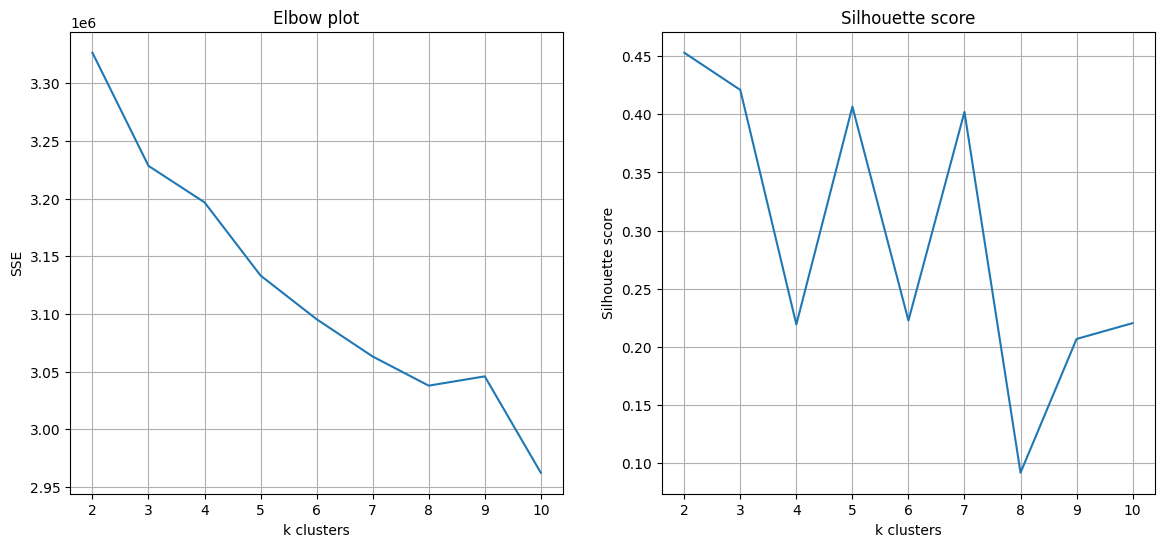

In [18]:

k_range = range(2, 11)
plot_kmeans(X, k_range)

In [19]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=50, n_init=1)
kmeans.fit(X)
labels=kmeans.predict(X)
silhouette_score(X,labels)

0.45303559644146707

In [20]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=50, n_init=1)
kmeans.fit(X)
labels=kmeans.predict(X)
silhouette_score(X,labels)

0.4210053225948719